In [1]:
import pandas as pd
import numpy as np

In [2]:
mappings = pd.read_csv(
    'mappings.txt',
    converters = {
        'name': lambda n: 'anon' if n == '' else n,
        'size': int,
        'referenced': int,
        'pss': int,
        'rss': int,
        'time': int,
        'cmd': str,
    })
mappings

,time,cmd,name,size,pss,rss,referenced
0,1633147693,/bin/bash /builds/jnewsome/sponsor-61-sims/mon...,anon,104,60,60,60
1,1633147693,/bin/bash /builds/jnewsome/sponsor-61-sims/mon...,[heap],132,96,96,96
2,1633147693,/bin/bash /builds/jnewsome/sponsor-61-sims/mon...,[stack],136,20,20,20
3,1633147693,/bin/bash /builds/jnewsome/sponsor-61-sims/mon...,[vdso],8,0,4,4
4,1633147693,/bin/bash /builds/jnewsome/sponsor-61-sims/mon...,[vvar],16,0,0,0
...,...,...,...,...,...,...,...
2911666,1633189108,tail -F /builds/jnewsome/sponsor-61-sims/jobs/...,[vdso],8,0,4,0
2911667,1633189108,tail -F /builds/jnewsome/sponsor-61-sims/jobs/...,[vvar],16,0,0,0
2911668,1633189108,tail -F /builds/jnewsome/sponsor-61-sims/jobs/...,ld-2.31.so,184,8,184,132
2911669,1633189108,tail -F /builds/jnewsome/sponsor-61-sims/jobs/...,libc-2.31.so,1976,24,1340,508


In [10]:
# Let's look at the top memory users by basename of the command
import os
mappings['cmd_base'] = mappings['cmd'].apply(lambda x: os.path.basename(x.split()[0]))
mappings.pivot_table(values='pss', index='cmd_base', aggfunc=np.sum).sort_values(by='pss', ascending=False)[:20]

,pss
cmd_base,
shadow,2347447133
tgen,480404731
tor,470542111
oniontrace,41723987
python3,20389635
bash,281474
grep,135505
sed,84843
tail,35018


In [11]:
# Let's filter to just some of the commands related to the simulation
filtered = mappings.loc[mappings['cmd_base'].isin([
    'shadow',
    'tor',
    'oniontrace',
    'tgen'])]
filtered

,time,cmd,name,size,pss,rss,referenced,cmd_base
147,1633147994,/builds/jnewsome/sponsor-61-sims/jobs/opt/onio...,anon,1426132,45056,45056,45056,oniontrace
148,1633147994,/builds/jnewsome/sponsor-61-sims/jobs/opt/onio...,[stack],508,508,508,508,oniontrace
149,1633147994,/builds/jnewsome/sponsor-61-sims/jobs/opt/onio...,[vdso],2720,0,1360,1360,oniontrace
150,1633147994,/builds/jnewsome/sponsor-61-sims/jobs/opt/onio...,[vvar],5440,0,0,0,oniontrace
151,1633147994,/builds/jnewsome/sponsor-61-sims/jobs/opt/onio...,gconv-modules.cache,9520,0,9520,9520,oniontrace
...,...,...,...,...,...,...,...,...
2911511,1633189108,/builds/jnewsome/sponsor-61-sims/jobs/opt/tor/...,libstdc++.so.6.0.28,1916,56,888,0,tor
2911512,1633189108,/builds/jnewsome/sponsor-61-sims/jobs/opt/tor/...,libz.so.1.2.11,112,8,104,0,tor
2911513,1633189108,/builds/jnewsome/sponsor-61-sims/jobs/opt/tor/...,shadow_memory_manager_4314_776_1000 (deleted),172356,9230,17860,15512,tor
2911514,1633189108,/builds/jnewsome/sponsor-61-sims/jobs/opt/tor/...,shadow_shmemfile_913777.346969298-4314,131072,2,68,40,tor


<AxesSubplot:xlabel='time'>

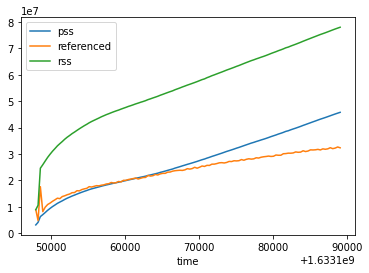

In [12]:
# Plot total PSS, rss, and referenced over time for related processes
filtered.loc[:,['time', 'pss', 'rss', 'referenced']].pivot_table(index='time', aggfunc=np.sum).plot()

<AxesSubplot:xlabel='time'>

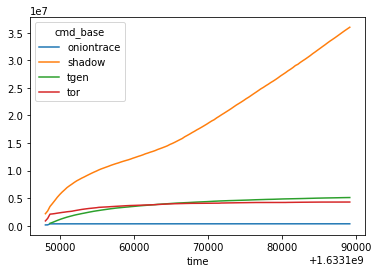

In [13]:
# Plot PSS over time by basename
filtered.pivot_table(index='time', columns='cmd_base', values='pss', aggfunc=np.sum).plot()

<AxesSubplot:xlabel='time'>

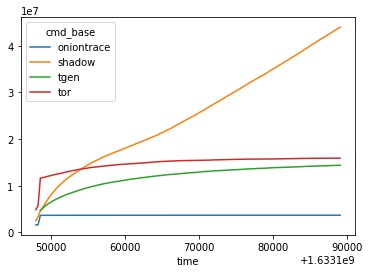

In [14]:
# Plot RSS over time by basename
filtered.pivot_table(index='time', columns='cmd_base', values='rss', aggfunc=np.sum).plot()

<AxesSubplot:xlabel='time'>

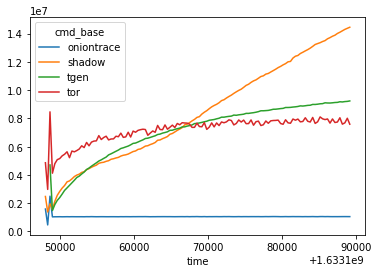

In [15]:
# Plot referenced over time by basename
filtered.pivot_table(index='time', columns='cmd_base', values='referenced', aggfunc=np.sum).plot()

In [17]:
# Breakdown of tor usage by mapping name
tor_top5_sections = filtered.loc[filtered['cmd_base'] == 'tor']\
.pivot_table(index='name', values='pss', aggfunc=np.sum)\
.sort_values(by='pss', ascending=False)[:5]
tor_top5_sections

,pss
name,
cached-descriptors,28755260
anon,20361408
libcrypto.so.1.1,17882058
tor,7140430
libstdc++.so.6.0.28,5383168


<AxesSubplot:xlabel='time'>

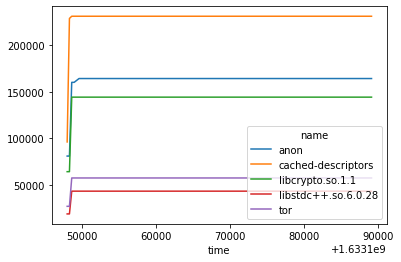

In [19]:
# Plot of top tor sections over time.
# Lots of heap - no surprise there.
# More than that is anon mappings, though. When using gperftools we should enable
# mmap-tracking to catch if these are being allocated outside of the default allocator.
filtered.loc[filtered['cmd_base'] == 'tor']\
.loc[lambda df: df['name'].isin(tor_top5_sections.index)]\
.pivot_table(index='time', values='pss', columns='name', aggfunc=np.sum).plot()

In [21]:
# zoom in on relay3guard to compare to heap profile
filtered.loc[filtered['cmd'].str.contains('relay1guard')]\
.loc[lambda t: t['name'].isin(['anon', '[heap]'])]\
.pivot_table(index='time', columns='name', values='pss', aggfunc=np.sum).plot()


TypeError: no numeric data to plot

In [ ]:
# zoom in on relay3guard region *sizes*, to see if
# this lines up better with heap profile
filtered.loc[filtered['cmd'].str.contains('relay3guard')]\
.loc[lambda t: t['name'].isin(['anon', '[heap]'])]\
.pivot_table(index='time', columns='name', values='size', aggfunc=np.sum).plot()


In [ ]:
# zoom in on relay3guard region *accessed*, to see if
# this lines up better with heap profile
filtered.loc[filtered['cmd'].str.contains('relay3guard')]\
.loc[lambda t: t['name'].isin(['anon', '[heap]'])]\
.pivot_table(index='time', columns='name', values='referenced', aggfunc=np.sum).plot()


In [22]:
def get_tor_type(cmd):
    try:
        fields = cmd.split()
        idx = fields.index('--Nickname') + 1
        n = fields[idx]
        return ''.join(c for c in n if not c.isdigit())
    except:
        return ''
mappings['tor_type'] = mappings['cmd'].apply(get_tor_type)

<AxesSubplot:xlabel='time'>

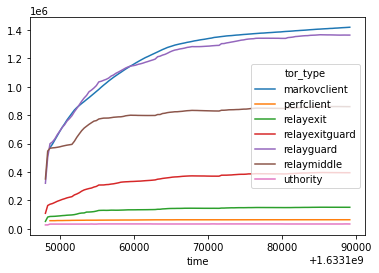

In [23]:
# Plot of top tor memory usage by type.
# Somewhat surprisingly type `relayguard` is using the most memory,
# despite there only being 2 of them, and despite guards being disabled in this sim
mappings.loc[mappings['tor_type'] != '']\
.pivot_table(index='time', values='pss', columns=['tor_type'], aggfunc=np.sum).plot()

<AxesSubplot:xlabel='time'>

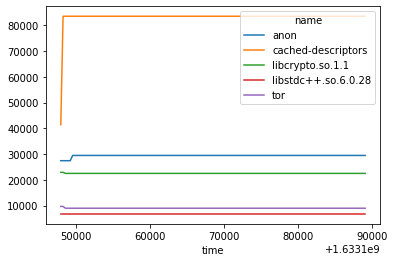

In [24]:
# Growth by section name for relayguards
mappings.loc[mappings['tor_type'] == 'relayguard']\
.loc[lambda x: x['name'].isin(tor_top5_sections.index)]\
.pivot_table(index='time', values='pss', columns=['name'], aggfunc=np.sum).plot()

<AxesSubplot:xlabel='time'>

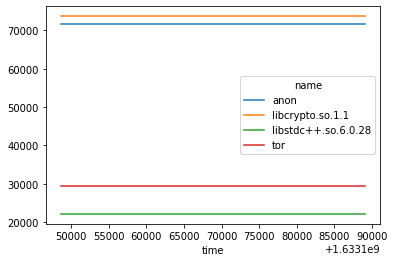

In [25]:
# Plot of top tor sections over time.
mappings\
.loc[lambda x: x['cmd'].str.contains('--Address markovclient')]\
.loc[lambda df: df['name'].isin(tor_top5_sections.index)]\
.pivot_table(index='time', values='pss', columns='name', aggfunc=np.sum).plot()

In [26]:
# Breakdown of shadow usage by mapping name
shadow_top5_sections = filtered.loc[filtered['cmd_base'] == 'shadow']\
.pivot_table(index='name', values='pss', aggfunc=np.sum)\
.sort_values(by='pss', ascending=False)[:5]
shadow_top5_sections

,pss
name,
anon,1393724288
[heap],158574240
shadow_memory_manager_4314_791_1000 (deleted),6127864
shadow_memory_manager_4314_807_1000 (deleted),6031672
shadow_memory_manager_4314_800_1000 (deleted),6023614


<AxesSubplot:xlabel='time'>

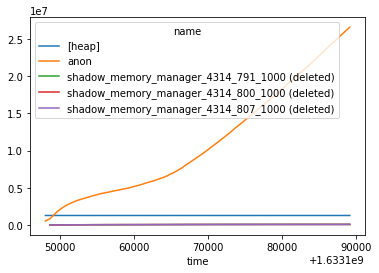

In [27]:
# Plot of top shadow sections over time.
# Surprisingly heap is flat, and it appears to be anon mappings that are growing.
# This clashes with the idea that packet retransmit queues are to blame, since
# the related objects are relatively small; almost certainly on the heap.
filtered.loc[filtered['cmd_base'] == 'shadow']\
.loc[lambda df: df['name'].isin(shadow_top5_sections.index)]\
.pivot_table(index='time', values='pss', columns='name', aggfunc=np.sum).plot()

In [28]:
# Now let's take a look at the slabinfos
slabinfos = pd.read_csv(
    'slabinfo.log',
    converters = {
        'time': int,
        'name': str,
        'active_objs': int,
        'num_objs': int,
        'objsize': int,
    })
slabinfos

FileNotFoundError: [Errno 2] No such file or directory: 'slabinfo.log'

In [ ]:
# Add a column for total obj_size
slabinfos['total_obj_size'] = slabinfos['num_objs'] * slabinfos['objsize']
slabinfos

In [ ]:
# What does total obj size look like over time?
slabinfos.pivot_table(index='time', values='total_obj_size', aggfunc=np.sum).plot()

In [ ]:
# How about active obj size over time?
slabinfos['total_active_obj_size'] = slabinfos['active_objs'] * slabinfos['objsize']
slabinfos

In [ ]:
slabinfos.loc[:, ['time', 'total_active_obj_size', 'total_obj_size']]\
.pivot_table(index='time', aggfunc=np.sum)\
.plot()

In [ ]:
# Get the top users over the duration
top_slab_allocs = slabinfos.loc[:, ['name', 'total_obj_size']]\
.pivot_table(index='name', aggfunc=np.sum)\
.sort_values(by='total_obj_size', ascending=False)
top_slab_allocs

In [ ]:
# Plot top users over time.
# 'buffer_head' doesn't tell us much
# 'ext4_inode_cache' isn't too surprising I guess - a lot of files are being accessed.
# Reassuring that nothing appears to be growing out of control, and that these appear
# to be unrelated to the relatively large number of processes (though this was only a
# 0.1% experiment with... 335 processes. So would be interesting to check this 
# again for a larger experiment)
slabinfos.loc[:, ['time', 'name', 'total_obj_size']]\
.loc[lambda df: df['name'].isin(top_slab_allocs.index[:5])]\
.pivot_table(index='time', columns='name', values='total_obj_size', aggfunc=np.sum)\
.plot()